# How do we define 'good' synthetic data?
In general, we hope a 'good' synthetic data to ensure optimum utility whilst not compromising privacy. We mainly evaluate our synthetic data from the following points.  

* **Distribution** — the synthetic data should 
    * capture the diversity, distribution between variables of the original data.
    * capture dependencies between variables of the original data.
* **Fidelity** — samples should be indistinguishable from the real data.
* **Usefulness** —synthetic data should be just as useful as the real data when used for the same predictive purposes. There are two different tasks, and hense we use different evalution methods for each task.
    * The synthetic data is used to train a model, which then will be deployed on real data. In this case, we apply TSTR (train on synthetic data and test on real data) and see how well the model performs.
    * The synthetic data is used to identify the best methods to use on the real data. In this case, we apply TSTS&TRTR and see if the model performs equally well on synthetic data and real data.
* **Privacy** – No real individual should be identifiable from the synthetic data.  

20% of the original data, not used in the generative model, is used for the evaluation methods (original evaluation sample). An equal size of the synthetic data is used for comparison (synthetic evaluation sample).

## 1 Distribution
### 1.1 Histogram for each _numerical_ column
This method is used to compare how similar the **diversity and distribution** of a _numerical_ variable (column).

For each numerical column, we draw two histograms for values from real and synthetic data in the same plot. The histogram can be viewed as a pdf (probability density function) plot. We also plot the corresponding cdf (cumulative density function).  

By viewing the graph we can have a subjective idea about how similar the distributions are. However, We also wish to compare similarity numerically. We apply <!-- [Text](link) -->
[Kolmogorov-Smirnov test](https://en.wikipedia.org/wiki/Kolmogorov%E2%80%93Smirnov_test "Optional Title")
. It is a hypothesis test which the null test is the two samples are drawn from the same distribution.

In [ ]:
def Histogram_KSTest(ori_nozero,gen_nozero,size = 100,syn_name=None):
    #syn_name is the name of the synthetic data generator
    keys = (ori_nozero.keys()).tolist()
    n = len(keys)
    l = min(len(ori_nozero),len(gen_nozero))

    import matplotlib.pyplot as plt
    from scipy import stats
    
    p_value = np.zeros(n)
    for num in range(n):
        name = keys[num]
        ser_ori = ori_nozero[name].values[:l]
        ser_gen = gen_nozero[name].values[:l]
        df= pd.DataFrame({'ori':ser_ori, 'gen':ser_gen})
        df.plot.hist(bins=100,alpha=0.5,cumulative=False)
        plt.title(syn_name+' '+name+'_pdf')
        df.plot.hist(bins=100,alpha=0.5,cumulative=True,histtype='step')
        plt.title(syn_name+' '+name+'_cdf')
        plt.show()

        value = [0,0]
        for k in range(10):
        #Randomly take 100 samples from the generated and real data, since the total sample size is 40,000+, which is too
        #large and the null hypothesis can get easily rejected, which actually doesn't make statistical sense.
            idx = np.random.permutation(l)
            idx = idx[:size]
            name = keys[num]
            ser_ori = ori_nozero[name].values[idx]
            ser_gen = gen_nozero[name].values[idx]
            (t,p) = stats.ks_2samp(ser_ori, ser_gen)
            value[0] = value[0]+t
            value[1] = value[1]+p
        value = np.array(value)/10
        p_value[num] = value[1]
        print('K-S test result:',value) #the displayed array is the average (statistic, p_value), the closer to 0 the p is
        #the null hypothesis is more likely to be rejected.
    p_series = pd.Series(p_value, index = keys)
    return p_series



In [ ]:
#load the data
import numpy as np
import pandas as pd
ori_df = pd.read_csv('synthetic data/2_no_id/ori_df.csv') #originally from cat_time_5abovevisits_all.csv. 
gen_1_df = pd.read_csv('synthetic data/2_no_id/gen_1_df.csv') #originally from gen_cat_time_10visits_wl_5000it_hd10_nl5.npy
gen_2_df = pd.read_csv('synthetic data/2_no_id/gen_2_df.csv') #originally from gen_cat_time_10visits_wl_5000it_hd10.
gen_3_df = pd.read_csv('synthetic data/2_no_id/gen_3_df.csv') #originally from gen_dop_cat_5abovevisits_d2g_e449.
gen_4_df = pd.read_csv('synthetic data/2_no_id/gen_4_df.csv') #originally from gen_cat_time_10visits_all_5000it.npy.
dp_ori_df = pd.read_csv('synthetic data/doppelGANger/dp_ori.csv') #originally ori_features_prism.npy
dp_gen_df = pd.read_csv('synthetic data/doppelGANger/dp_gen.csv') #originally features_600.npy
tgan_ori_df = pd.read_csv('synthetic data/TGAN/tgan_ori.csv') #originally cat_time_10visits_all_noid.csv
tgan_gen_df = pd.read_csv('synthetic data/TGAN/tgan_gen.csv') #originally gen_cat_time_10visits_wl_5000it.npy



In [ ]:
# Lulu's Data Loading when working from Colab
import numpy as np
import pandas as pd
ori_df = pd.read_csv('ori_df.csv') #originally from cat_time_5abovevisits_all.csv. 
gen_1_df = pd.read_csv('gen_1_df.csv') #originally from gen_cat_time_10visits_wl_5000it_hd10_nl5.npy
gen_2_df = pd.read_csv('gen_2_df.csv') #originally from gen_cat_time_10visits_wl_5000it_hd10.
gen_3_df = pd.read_csv('gen_3_df.csv') #originally from gen_dop_cat_5abovevisits_d2g_e449.
gen_4_df = pd.read_csv('gen_4_df.csv') #originally from gen_cat_time_10visits_all_5000it.npy.
dp_ori_df = pd.read_csv('dp_ori.csv') #originally ori_features_prism.npy
dp_gen_df = pd.read_csv('dp_gen.csv') #originally features_600.npy
tgan_ori_df = pd.read_csv('tgan_ori.csv') #originally cat_time_10visits_all_noid.csv
tgan_gen_df = pd.read_csv('tgan_gen.csv') #originally gen_cat_time_10visits_wl_5000it.npy



Lulu:
* did not alter preprocessing
* rewrote dictionary with correct ori/gen pairs for comparison
* changed range(n) to looping through dictionary keys directly

In [ ]:
#Remove all-zero rows. 
#The data uses all-zero rows to mark as an end to the time sequence and to make the time sequence length for each sample same. 
#However, in this test, we don't need time sequence length to be the same and lots of zeros can result in a heavy bias.
dp_ori_nozero = dp_ori_df[np.any(abs(dp_ori_df)!=0,axis=1)].copy()
dp_gen_nozero = dp_gen_df[np.any(abs(dp_gen_df)!=0,axis=1)].copy()
tgan_ori_nozero = tgan_ori_df[np.any(abs(tgan_ori_df)!=0,axis=1)].copy()
tgan_gen_nozero = tgan_gen_df[np.any(abs(tgan_gen_df)!=0,axis=1)].copy()

#Remove all categorical columns
ori_num = ori_df.iloc[:,:6]
gen_1_num = gen_1_df.iloc[:,:6]
gen_2_num = gen_2_df.iloc[:,:6]
gen_3_num = gen_3_df.iloc[:,:6]
gen_4_num = gen_4_df.iloc[:,:6]
tgan_ori_nozero_num = tgan_ori_nozero.iloc[:,:6]
tgan_gen_nozero_num = tgan_gen_nozero.iloc[:,:6]

#Set up a dictionary for furture loop
# synthetic_num_dic = {'DoppelGANger ini':[dp_ori_nozero,dp_gen_nozero],'tGAN':[tgan_ori_nozero_num,tgan_gen_nozero_num],\
#                       'gen 1':[tgan_ori_nozero_num,gen_1_num],'gen 2':[tgan_ori_nozero_num,gen_2_num],'gen 3':[ori_num,gen_3_num],\
#                       'gen 4':[tgan_ori_nozero_num,gen_4_num]}
# syn_keys = list(synthetic_num_dic.keys())
# n = len(syn_keys)

# Lulu:
ori_gen_pairs = {'DoppelGANger_0824':[ori_num, gen_3_num], 
                 'DoppelGANger_0814':[dp_ori_nozero, dp_gen_nozero], 
                'tGAN': [tgan_ori_nozero_num, tgan_gen_nozero_num], 
                'tGAN_1':[tgan_ori_nozero_num, gen_1_num], 
                'tGAN_2':[tgan_ori_nozero_num, gen_2_num],
                'tGAN_4':[tgan_ori_nozero_num, gen_4_num]
                }


In [21]:
# Lulu: getting hist data after preprocessing - for Rebeca's D3
hist_data = [ori_num, gen_3_num, dp_ori_nozero, dp_gen_nozero, tgan_ori_nozero_num, tgan_gen_nozero_num, gen_1_num, gen_2_num, gen_4_num]
new_file_names = ['ori_num.csv', 'gen_3_num.csv', 'dp_ori_nozero.csv', 'dp_gen_nozero.csv', 'tgan_ori_nozero_num.csv', 'tgan_gen_nozero_num.csv', 'gen_1_num.csv', 'gen_2_num.csv', 'gen_4_num.csv']
for i in range(len(hist_data)):
  hist_data[i].to_csv(new_file_names[i], index=False)

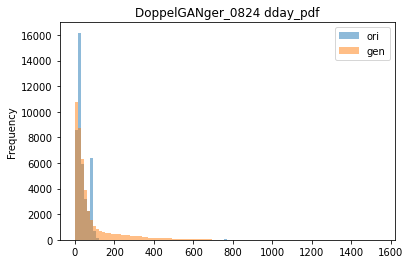

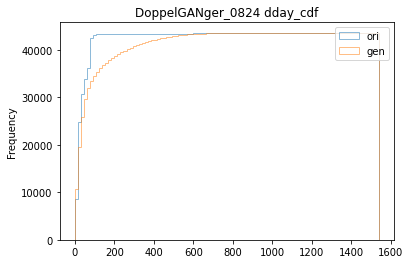

K-S test result: [0.22       0.03697866]


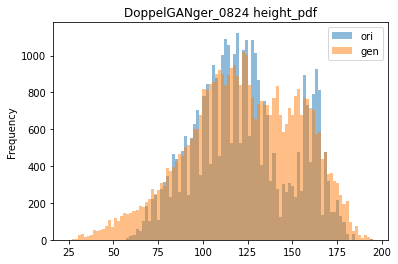

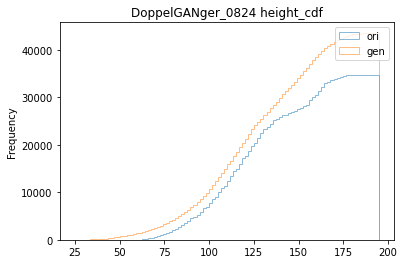

K-S test result: [0.228     0.0368737]


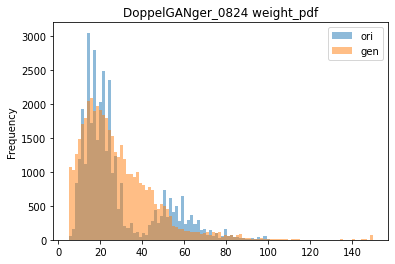

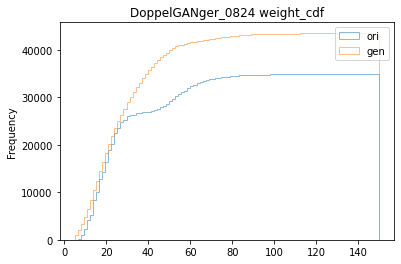

K-S test result: [0.292     0.0013974]


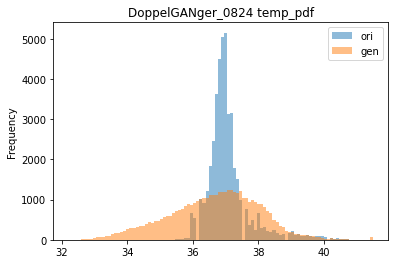

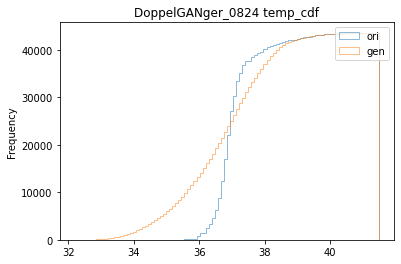

K-S test result: [0.315      0.00045726]


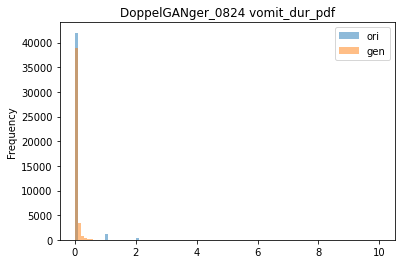

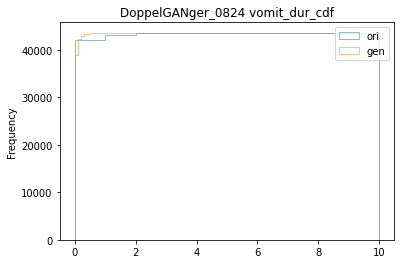

K-S test result: [5.62000000e-01 3.57548934e-08]


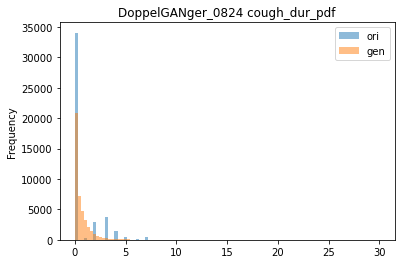

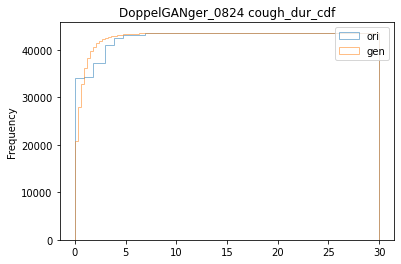

K-S test result: [5.75000000e-01 2.36416148e-11]


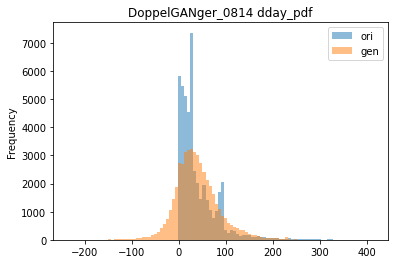

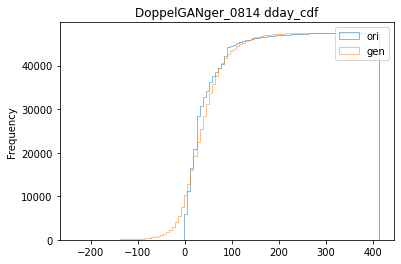

K-S test result: [0.191      0.11517228]


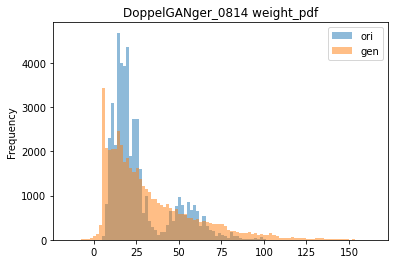

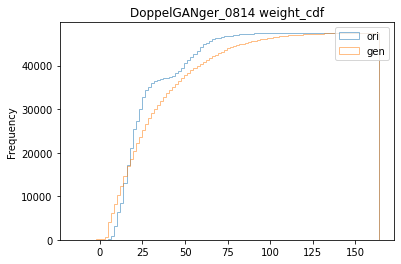

K-S test result: [0.2        0.06143229]


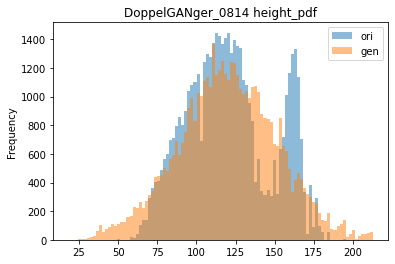

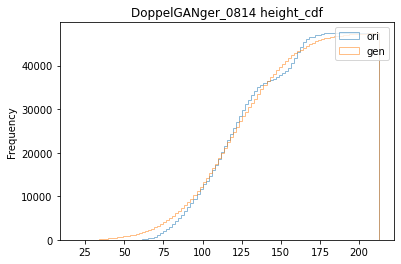

K-S test result: [0.131     0.4654704]


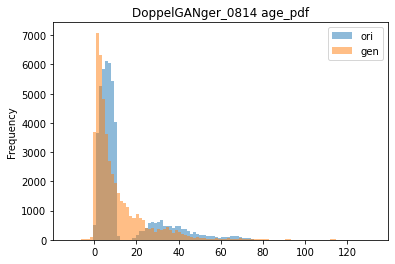

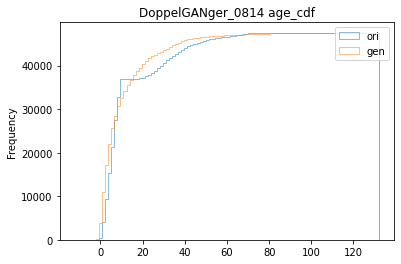

K-S test result: [0.249      0.01506324]


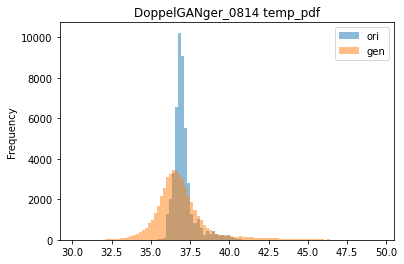

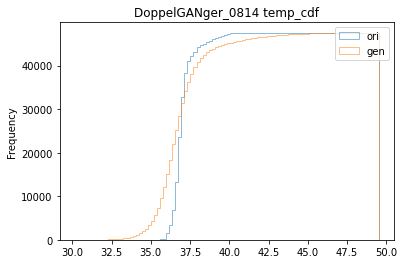

K-S test result: [0.314      0.00076495]


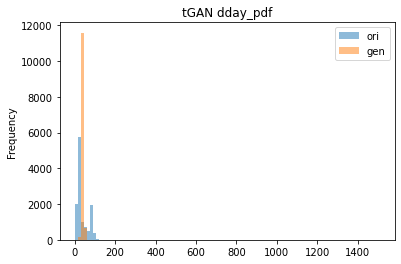

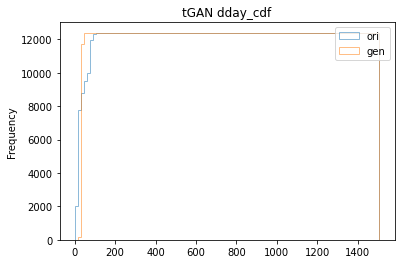

K-S test result: [6.66000000e-01 4.94047094e-18]


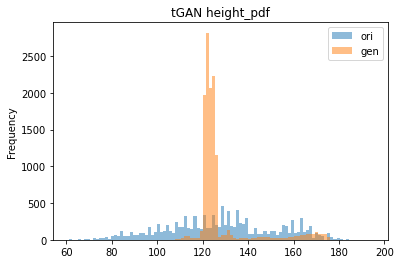

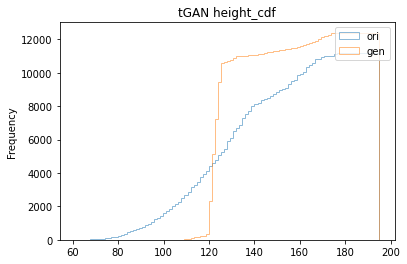

K-S test result: [4.32000000e-01 8.29675331e-07]


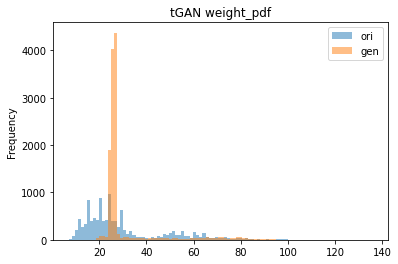

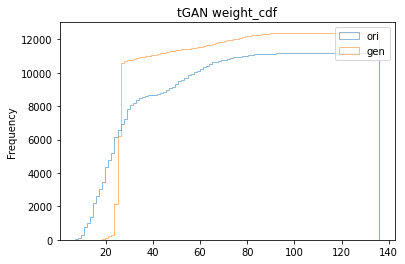

K-S test result: [4.54000000e-01 3.91745578e-07]


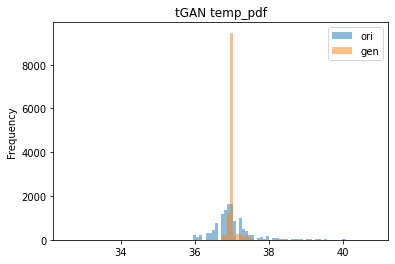

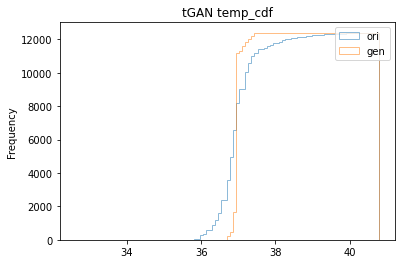

K-S test result: [5.14000000e-01 9.24681485e-11]


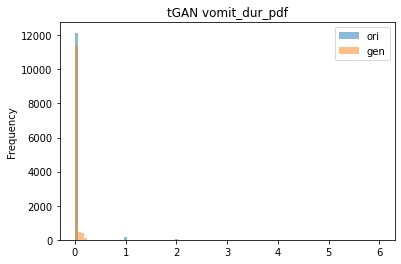

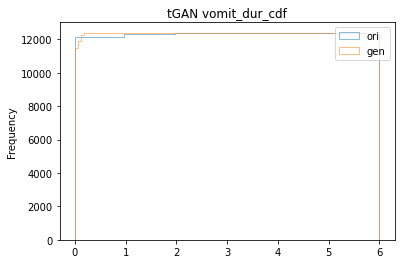

K-S test result: [9.80000000e-01 5.60372271e-51]


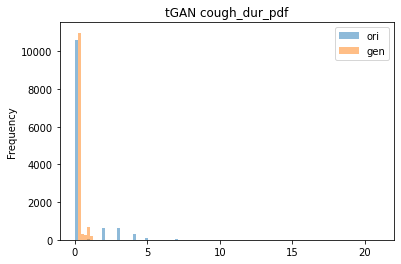

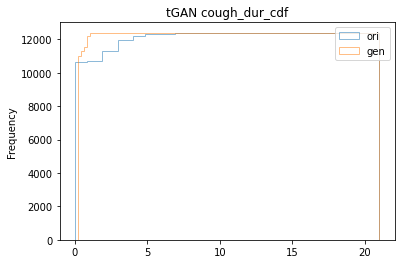

K-S test result: [8.59000000e-01 3.98297888e-34]


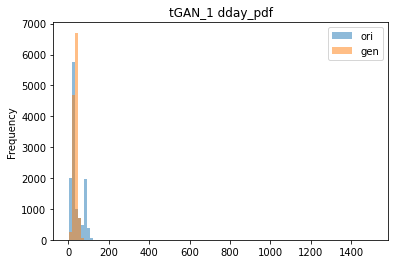

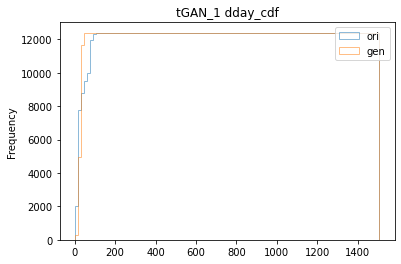

K-S test result: [3.63000000e-01 3.86917994e-05]


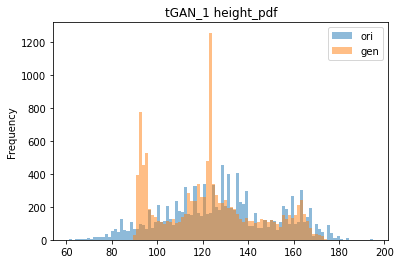

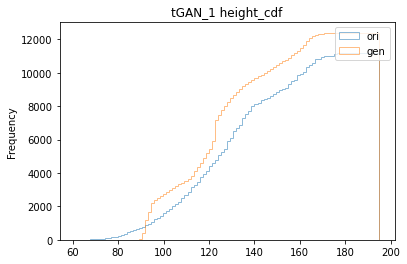

K-S test result: [0.207      0.07058577]


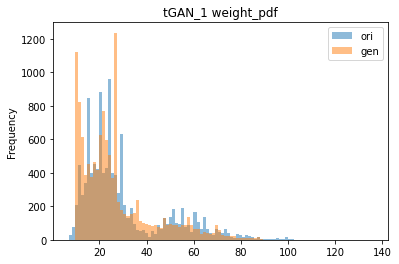

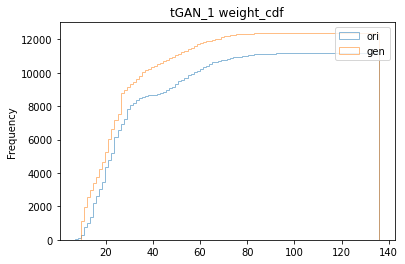

K-S test result: [0.179      0.15806322]


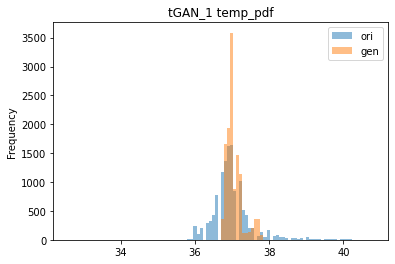

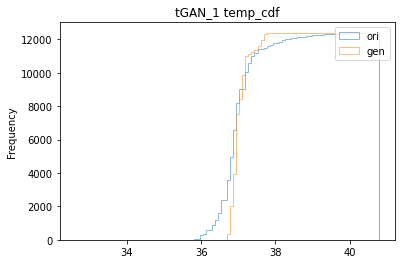

K-S test result: [3.50000000e-01 9.69836123e-05]


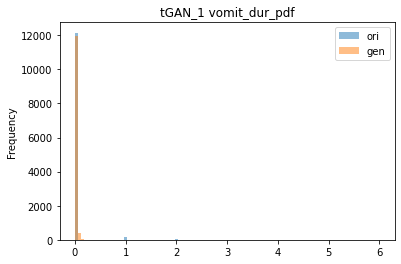

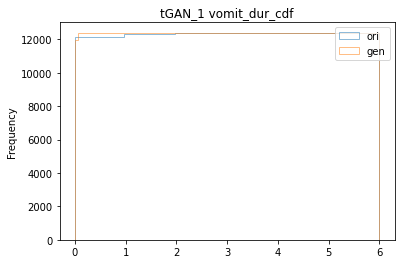

K-S test result: [9.76000000e-01 5.75516606e-51]


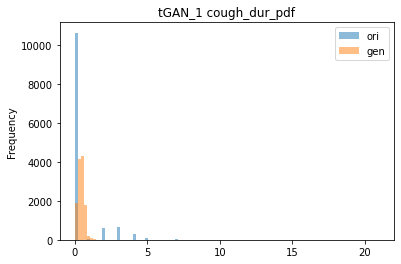

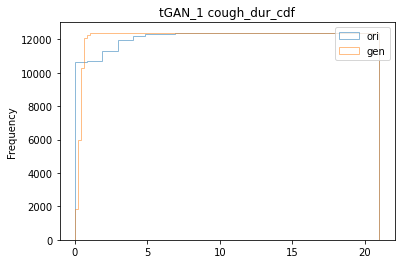

K-S test result: [8.79000000e-01 4.11204421e-35]


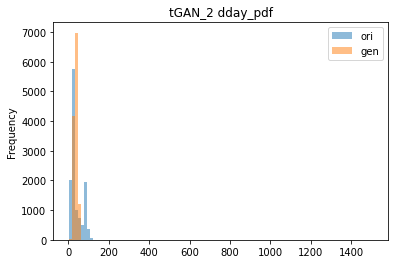

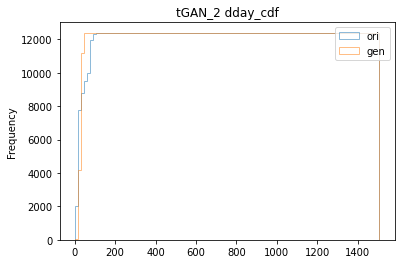

K-S test result: [4.14000000e-01 7.55195124e-05]


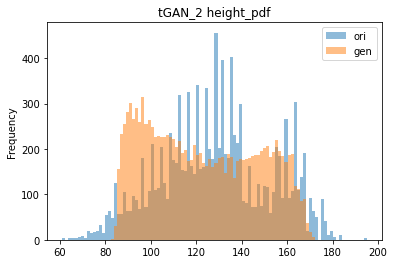

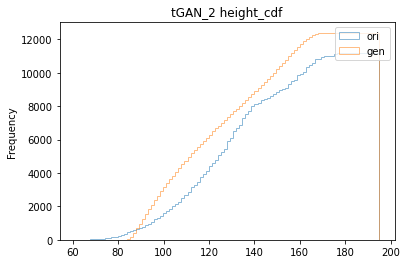

K-S test result: [0.219      0.04303997]


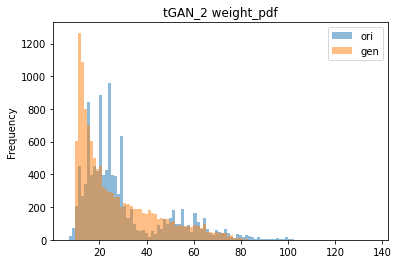

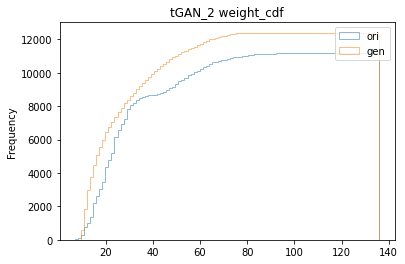

K-S test result: [0.214      0.03302609]


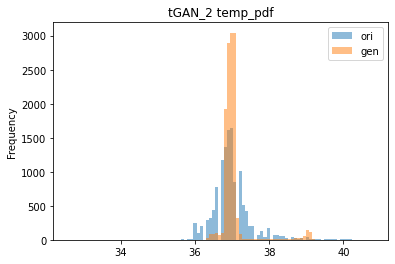

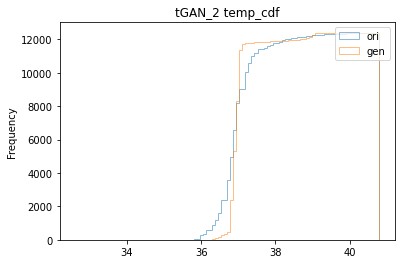

K-S test result: [3.74000000e-01 5.86937653e-06]


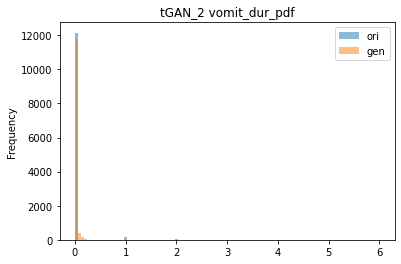

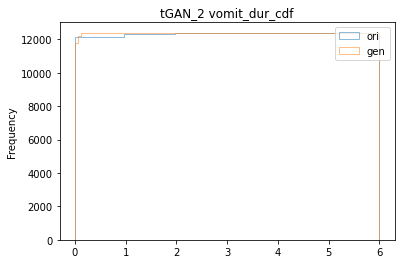

K-S test result: [9.90000000e-01 4.74905637e-56]


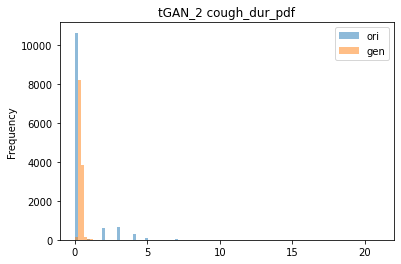

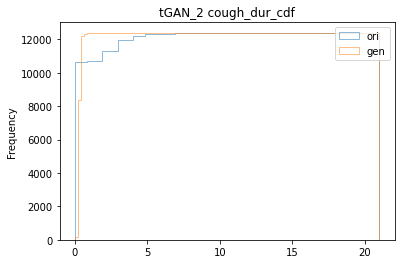

K-S test result: [8.63000000e-01 3.05940138e-32]


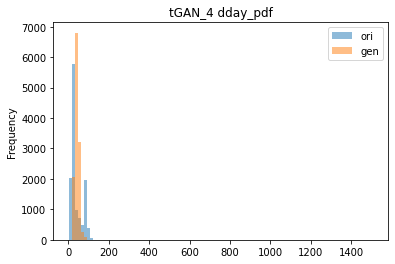

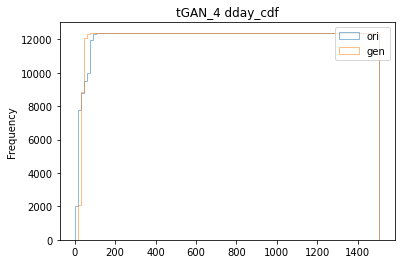

K-S test result: [4.97000000e-01 1.75787452e-07]


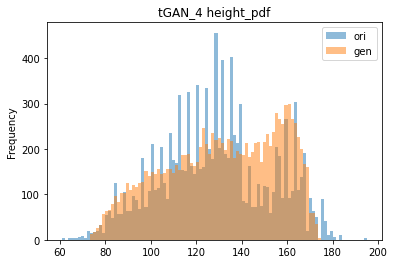

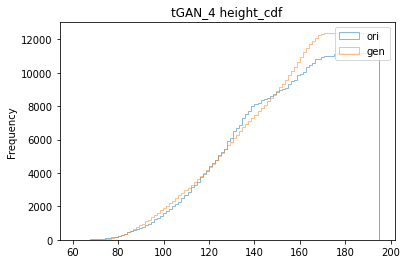

K-S test result: [0.158      0.21174176]


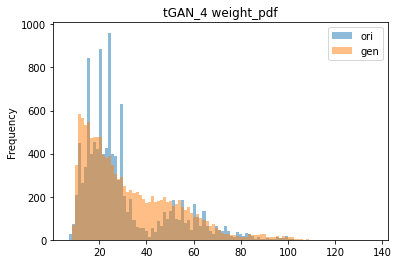

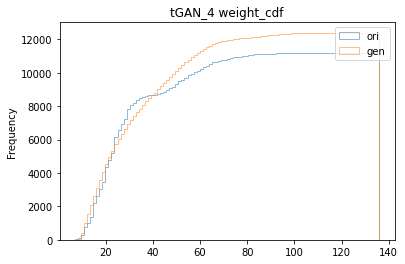

K-S test result: [0.157      0.21742874]


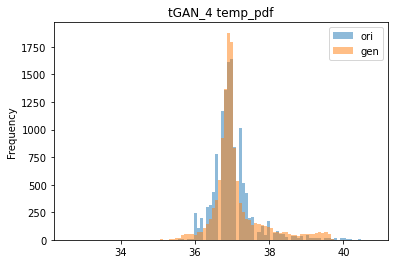

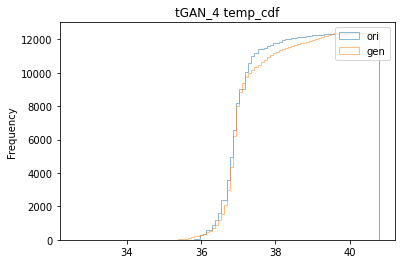

K-S test result: [0.186      0.17698329]


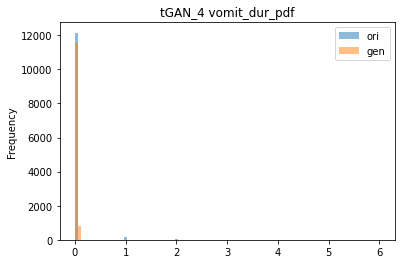

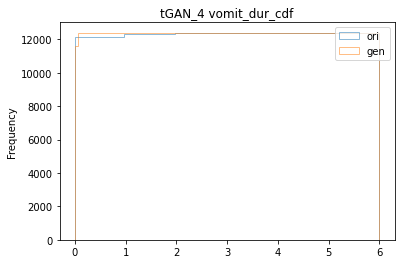

K-S test result: [9.85000000e-01 5.93516528e-54]


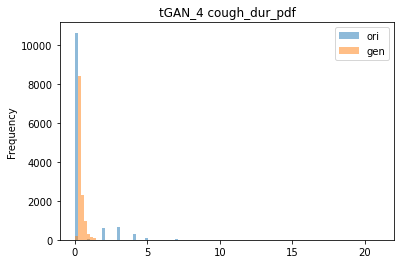

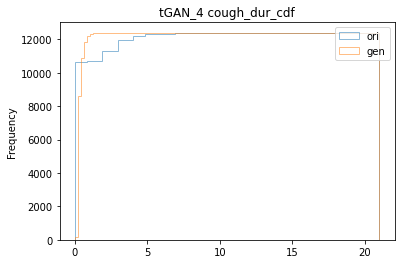

K-S test result: [8.56000000e-01 3.41250156e-32]


In [ ]:
#Implement with all synthetic data and the corresponding real data.
# for i in range(n):
#     key = syn_keys[i]
#     p_series = Histogram_KSTest(synthetic_num_dic[key][0],synthetic_num_dic[key][1],syn_name = key)
#     if i == 0:
#         p_df = pd.DataFrame(p_series,columns = [key])
#     else:
#         p_df = pd.concat([p_df,pd.DataFrame(p_series,columns = [key])],axis=1,sort = False)

# Lulu: looping directly through dict
def get_p_df_from_dict(pairs_dict):
  
  p_df_list = []
  for pair in pairs_dict:
    p_series = Histogram_KSTest(pairs_dict[pair][0], pairs_dict[pair][1], syn_name = pair)
    p_df_list.append(pd.DataFrame(p_series, columns = [pair]))

  p_df = pd.concat(p_df_list, axis=1, sort = False)
  return p_df

p_df = get_p_df_from_dict(ori_gen_pairs)
p_df.to_csv('KS_similarity_allpairs.csv')

In [ ]:
pd.set_option('display.float_format', lambda x: '%.7f' % x)
display('p value table',p_df)

'p value table'

,DoppelGANger_0824,DoppelGANger_0814,tGAN,tGAN_1,tGAN_2,tGAN_4
dday,0.0369787,0.1151723,0.0000000,0.0000387,0.0000755,0.0000002
height,0.0368737,0.4654704,0.0000008,0.0705858,0.0430400,0.2117418
weight,0.0013974,0.0614323,0.0000004,0.1580632,0.0330261,0.2174287
temp,0.0004573,0.0007649,0.0000000,0.0000970,0.0000059,0.1769833
vomit_dur,0.0000000,nan,0.0000000,0.0000000,0.0000000,0.0000000
cough_dur,0.0000000,nan,0.0000000,0.0000000,0.0000000,0.0000000
age,nan,0.0150632,nan,nan,nan,nan


## Conclusions
* The closer the p to 1, the more similar the distribution of the synthetic data is to the original data. 
* It looks like the initial doppelGANger ini and gen 4 are averagely better than others. DoppelGANger ini does particularly well in dday and height, gen 4 does particularly well in weight and temp (though the height is good as well)
* All data performs not so well in vomit_dur and cough_dur, from the pdf we can see that they don't include duration day > 1.

### 1.2 Scatter plot for _categorical_ columns
This method is used to compare how similar the **diversity and distribution** of a _categorical_ variable (column).  

For One-hot-encoded categorical variables (only TGANs data contains categorical variables now), we hope to plot a scatter graph of the proportion of '1' and '0' in each column in the synthetic data against that in the real data. An ideal synthetic data should lie on the diagonal $ y=x $.

The table below shows the proportion values. Note there are 8 rows but there are only 4 points in the scatter graph. This is because, for example, '0' in diar_No has to mean '1' in diar_Yes logically.

In [43]:
def Scatter_Distance(ori_data, gen_data, syn_name = None):
    #syn_name is the name of the synthetic data generator e.g. 'tGAN'
    import matplotlib.pyplot as plt
    from math import sqrt
    
    #since the categorical variables are OHE, so we regard entries > 0.5 as 1, entries < 0.5 as 0 for gen_data
    gen_data = gen_data[gen_data<0.5].fillna(1)
    gen_data = gen_data[gen_data>0.5].fillna(0)
    
    def CatProportion(series):
        return series.value_counts()/len(series)

    cat_keys = (gen_data.keys()).tolist()
    first = True
    name_index = []
    cat_index = []
    for name in cat_keys:
        df_1=pd.DataFrame({'gen':CatProportion(gen_data[name]),'ori': CatProportion(ori_data[name])})
        if first:
            v = df_1.values
            first = False
        else:
            v = np.concatenate((v,df_1.values),axis = 0)
        df1_index = df_1.index.tolist()
        name_index += [name]*len(df1_index)
        cat_index += df1_index

    df_cat = pd.DataFrame(v, index = [name_index,cat_index], columns = [syn_name+ '_generated',syn_name+'_original']) # Lulu: removed space in col names
    df_cat = df_cat.fillna(0)
    df_cat.to_csv(syn_name+'_df_cat.csv') # Lulu: Added export ability
    display(df_cat)
    plt.scatter(df_cat[syn_name+ '_generated'],df_cat[syn_name+'_original'],c = 'r') # Lulu: removed space in col names
    plt.plot([0,1])
    plt.show()
    
    def PtToDiagnalDist(coordinates, aver = True):
        '''
        For a series of points(2D), calculate the distance between each points and the diagonal y=x
        
        Args: 
        coordinates: array in shape (n,2), n is the number of points
        aver: True(default) or False. If aver == True, the distances are averaged, otherwise a list of distances is returned
        
        Returns:
        a: a list of distances, returned when aver==False
        np.sum(a)/n: the average of distances, returned when aver == True
        '''
        n = len(coordinates)
        a = np.zeros(n)
        for i in range(n):
            x = coordinates[i][0]
            y = coordinates[i][1]
            d = abs(x-y)/sqrt(2) #formula to calculate the distance between point (X,Y) and line ax+by+c = 0 is
            # abs(aX+bY+c)/abs(a^2+b^2)
            a[i]=d
        if aver:
            return np.sum(a)/n
        else:
            return a
    distance = PtToDiagnalDist(df_cat.values)
    return distance


In [37]:
#Remove all numerical columns
tgan_ori_cat = tgan_ori_nozero.iloc[:,6:]
tgan_gen_cat = tgan_gen_nozero.iloc[:,6:]
ori_cat = ori_df.iloc[:,6:]
gen_1_cat = gen_1_df.iloc[:,6:]
gen_2_cat = gen_2_df.iloc[:,6:]
gen_3_cat = gen_3_df.iloc[:,6:]
gen_4_cat = gen_4_df.iloc[:,6:]
tgan_ori_nozero_cat = tgan_ori_nozero.iloc[:,6:]
tgan_gen_nozero_cat = tgan_gen_nozero.iloc[:,6:]

#Set up a dictionary for furture loop
# synthetic_cat_dic = {'tGAN':[tgan_ori_cat,tgan_gen_cat],\
#                       'gen 1':[tgan_ori_cat,gen_1_cat],'gen 2':[tgan_ori_cat,gen_2_cat],'gen 3':[ori_cat,gen_3_cat],\
#                       'gen 4':[tgan_ori_cat,gen_4_cat]}
# syn_keys = list(synthetic_cat_dic.keys())
# n = len(syn_keys)

# Lulu:
ori_gen_pairs_cat.clear()
ori_gen_pairs_cat = {'DoppelGANger_0824':[ori_cat, gen_3_cat], 
                  # 'DoppelGANger_0814':[dp_ori_nozero_cat, dp_gen_nozero_cat], 
                  'tGAN': [tgan_ori_nozero_cat, tgan_gen_nozero_cat], 
                  'tGAN_1':[tgan_ori_nozero_cat, gen_1_cat], 
                  'tGAN_2':[tgan_ori_nozero_cat, gen_2_cat],
                  'tGAN_4':[tgan_ori_nozero_cat, gen_4_cat]
                  }

DoppelGANger_0824_generated  DoppelGANger_0824_original
diar_No  1.0000000                    0.9887419                   0.9683223
         0.0000000                    0.0112581                   0.0316777
diar_Yes 0.0000000                    0.9887419                   0.9683223
         1.0000000                    0.0112581                   0.0316777
head_No  1.0000000                    0.9474469                   0.8813273
         0.0000000                    0.0525531                   0.1186727
head_Yes 0.0000000                    0.9474469                   0.8813273
         1.0000000                    0.0525531                   0.1186727

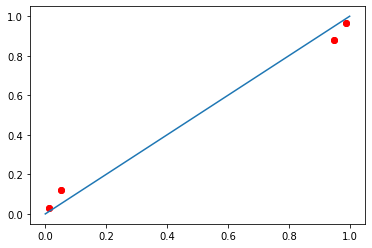

tGAN_generated  tGAN_original
diar_No  0.0000000       0.0000000      0.0223567
         1.0000000       1.0000000      0.9776433
diar_Yes 0.0000000       1.0000000      0.9776433
         1.0000000       0.0000000      0.0223567
head_No  1.0000000       0.9064568      0.8893462
         0.0000000       0.0935432      0.1106538
head_Yes 0.0000000       0.9064568      0.8893462
         1.0000000       0.0935432      0.1106538

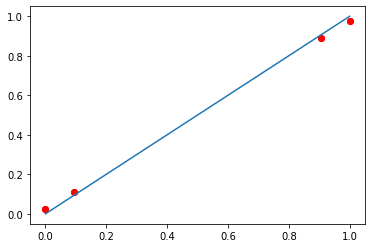

tGAN_1_generated  tGAN_1_original
diar_No  1.0000000         0.9991929        0.9776433
         0.0000000         0.0008071        0.0223567
diar_Yes 0.0000000         0.9991929        0.9776433
         1.0000000         0.0008071        0.0223567
head_No  1.0000000         0.8666667        0.8893462
         0.0000000         0.1333333        0.1106538
head_Yes 0.0000000         0.8675545        0.8893462
         1.0000000         0.1324455        0.1106538

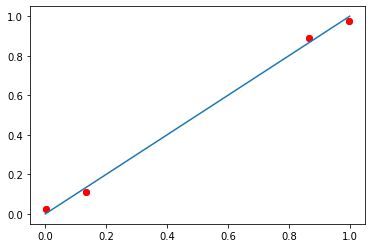

tGAN_2_generated  tGAN_2_original
diar_No  1.0000000         0.9928168        0.9776433
         0.0000000         0.0071832        0.0223567
diar_Yes 0.0000000         0.9953188        0.9776433
         1.0000000         0.0046812        0.0223567
head_No  1.0000000         0.9020985        0.8893462
         0.0000000         0.0979015        0.1106538
head_Yes 0.0000000         0.9022599        0.8893462
         1.0000000         0.0977401        0.1106538

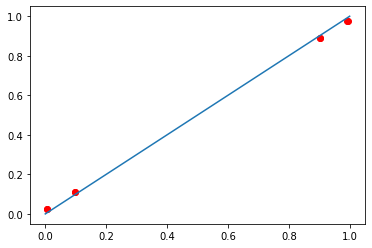

tGAN_4_generated  tGAN_4_original
diar_No  0.0000000         0.0000000        0.0223567
         1.0000000         1.0000000        0.9776433
diar_Yes 0.0000000         1.0000000        0.9776433
         1.0000000         0.0000000        0.0223567
head_No  1.0000000         0.8959645        0.8893462
         0.0000000         0.1040355        0.1106538
head_Yes 0.0000000         0.8959645        0.8893462
         1.0000000         0.1040355        0.1106538

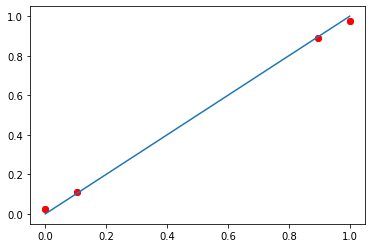

'average distance to the diagonal'

DoppelGANger_0824   0.0305962
tGAN                0.0139538
tGAN_1              0.0154804
tGAN_2              0.0103441
tGAN_4              0.0102442
dtype: float64

In [44]:
#Implement with all synthetic data and the corresponding real data.
# d_array = np.zeros(n)
# for i in range(n):
#     key = syn_keys[i]
#     distance = Scatter_Distance(synthetic_cat_dic[key][0],synthetic_cat_dic[key][1],syn_name = key)
#     d_array[i] = distance
# distance_series= pd.Series(d_array,index = syn_keys)
# display('average distance to the diagonal', distance_series)

# Lulu: looping directly through dict
def get_distance_series_from_dict(pairs_dict):
  d_list=[]
  for pair in pairs_dict:
      distance = Scatter_Distance(pairs_dict[pair][0], pairs_dict[pair][1], syn_name = pair)
      d_list.append(distance)
  distance_series = pd.Series(d_list,index = pairs_dict.keys())
  return distance_series


distance_series = get_distance_series_from_dict(ori_gen_pairs_cat)
distance_series.to_csv('distance_series.csv')
display('average distance to the diagonal', distance_series)

## Conclusion
* The smaller the average distance, the more similar the categorical column distribution of the synthetic data is to the real data.  

* The large average distance of gen 3 is mainly due to it does bad in 'head_NO'/'head_Yes'.  

* Though tgan and gen 4 gives small distance value, but they completely ignore diar_Yes.

**Reference:**
* <!--[Text](link)-->
[Ramiro D. Camino, Christian A. Hammerschmidt, Radu State.Generating Multi-Categorical Samples with Generative Adversarial Networks](https://arxiv.org/pdf/1807.01202.pdf)
* <!--[Text](link)-->
[Jinsung Yoon, Daniel Jarrett, Mihaela van der Schaar. Time-series Generative Adversarial Networks](https://papers.nips.cc/paper/8789-time-series-generative-adversarial-networks.pdf 'Optional title')
